In [18]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import cv2
import math
import pandas as pd
from CSL_2025_Python_codes import spim2XYZ, XYZ2Lab, spim2rgb
from functions import *

1. Load Spectral Reflectances Cubes


In [19]:
# Define parameters
# Wether we want to use initial samples (False) or test samples (True)
test = True 

# The test trial (1 or 2)
trial = 1 

# The operator (1 or 2 or 3)
operator = 2

In [20]:
# Define folder path
base_folder = "../IDP Group A"
if test: base_folder = "../test"+str(trial)+"/operator"+str(operator) 

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
if test: sample_folders = ['d0', 'd3', 'd4', 'd7', 'd10', 'd12', 'd13', 'd18', 'd19', 'd20', 'd21', 'd22']

dark_folder = "dark"
white_folder = "white"
reference_folder = "../IDP Group A/reference" # reference is always the same


# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube


# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(reference_folder)
#reference_cube = load_cube(base_folder+ "/d0")


# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

# Load and compute reflectance for each sample
defect_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    defect_cubes[folder] = R  # Shape: (bands, height, width)

2. Reference


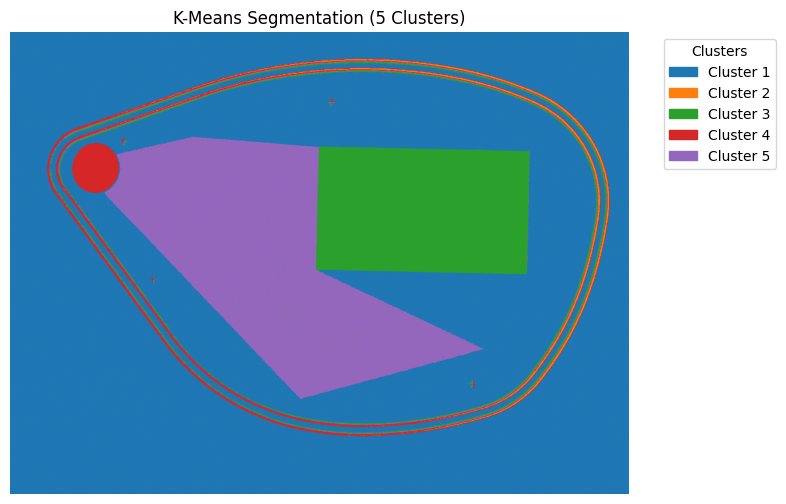

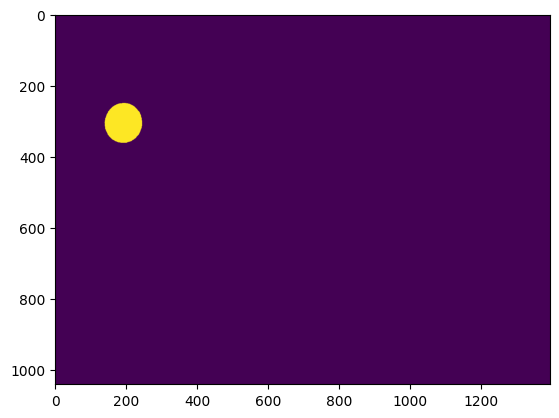

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


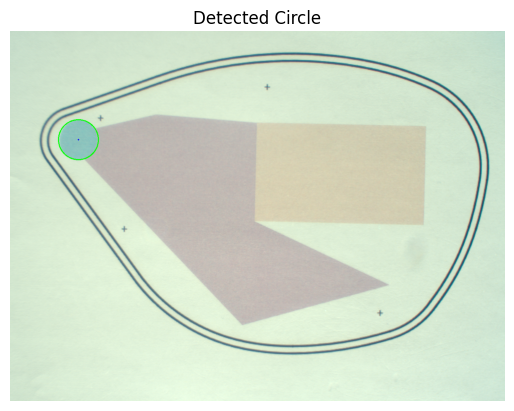

Reflectance shape: (26, 1040, 1392)
RGB shape: (1040, 1392, 3)
Mask shape: (1040, 1392)
Single band shape: (1040, 1392)
Binary shape: (1040, 1392)
circle_info: {'centroid': (191.9990336578784, 305.7174634430952), 'area': 9141.0, 'perimeter': 359.0193339586258, 'min_enclosing_circle': {'center': (192.35105895996094, 305.67022705078125), 'radius': 56.19334030151367}, 'ellipse': ((192.0535125732422, 305.713134765625), (104.27791595458984, 111.74099731445312), 7.756130218505859), 'circularity': 0.8911850638627173}


In [21]:
R_sample = (reference_cube - dark_cube) / denominator

band = 550  # Band for alignment

ref_rgb = spim2rgb(R_sample, wavelengths)
ref_mask = compute_IC_mask(ref_rgb)
ref_single_band = R_sample[wavelengths.index(band), :, :]
ref_binary = convert_binary_image(ref_single_band)
ref_circle_info = get_circle_info(ref_mask, ref_rgb, True)
center_pixel = (
    int(ref_circle_info["centroid"][0]),
    int(ref_circle_info["centroid"][1]),
)
"""if ref_rgb.dtype != np.uint8:
    ref_rgb = np.clip(ref_rgb * 255, 0, 255).astype(np.uint8)"""

circle_center = ref_circle_info["min_enclosing_circle"]["center"]
circle_radius = ref_circle_info["min_enclosing_circle"]["radius"]
ref_spectrum = average_reflectance_in_circle(R_sample, circle_center, circle_radius)
spectra = {"reference": ref_spectrum}
R_sample_interp, new_wavelengths = interpolate_spectral_cube(
    R_sample, wavelengths, wl_min=360, wl_max=830, wl_step=10
)
R_sample_interp = np.transpose(R_sample_interp, (1, 2, 0))  # (H, W, bands)

ref_XYZ = spim2XYZ(R_sample_interp, new_wavelengths, "D65")
ref_LAB = XYZ2Lab(ref_XYZ, new_wavelengths, "D65")

mask_ref = np.zeros(ref_LAB.shape[:2], dtype=np.uint8)
cx, cy = int(circle_center[0]), int(circle_center[1])
r = int(circle_radius) - 5
cv2.circle(mask_ref, (cx, cy), r, 1, -1)

ref_cropped = crop_circle(ref_rgb, circle_center, circle_radius)
cropped_circles = [ref_cropped]

print(f"Reflectance shape: {R_sample.shape}")
print(f"RGB shape: {ref_rgb.shape}")
print(f"Mask shape: {ref_mask.shape}")
print(f"Single band shape: {ref_single_band.shape}")
print(f"Binary shape: {ref_binary.shape}")
print(f"circle_info: {ref_circle_info}")

3. Find Homography matrix for the alignment of each defect


In [22]:
defect_homographies = []
defects = sample_folders
for defect in defects:
    print(f"Aligning {defect}...")

    defect_rgb = spim2rgb(defect_cubes[defect], wavelengths)
    defect_binary = convert_binary_image(
        get_example_reflectance(defect_cubes, defect, band)
    )
    H = align_and_visualise_homography(
        ref_binary, defect_binary, defect, visualise=False
    )
    defect_homographies.append(H)

    if ref_rgb.dtype != np.uint8:
        ref_rgb = np.clip(ref_rgb * 255, 0, 255).astype(np.uint8)
    if defect_rgb.dtype != np.uint8:
        defect_rgb = np.clip(defect_rgb * 255, 0, 255).astype(np.uint8)

    # aligned_defect, blended = align_and_blend_RGB_homography(ref_rgb, defect_rgb, H, defect)
    # overlay_mask(defect_rgb, ref_mask, defect, color=(1, 0, 0), alpha=0.5)
    # overlay_mask(aligned_defect, ref_mask, f"aligned_{defect}", color=(1, 0, 0), alpha=0.5)

Aligning d0...
Aligning d3...
Aligning d4...
Aligning d7...
Aligning d10...
Aligning d12...
Aligning d13...
Aligning d18...
Aligning d19...
Aligning d20...
Aligning d21...
Aligning d22...


4. CTQs without allignment

In [23]:
"""import cv2
import numpy as np
def preprocess(img):

    # CLAHE contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(img)

    # Smooth edges to reduce noise
    gray = cv2.GaussianBlur(gray, (7,7), 1.5)

    # Optional: sharpen edges
    kernel = np.array([[0,-1,0],
                       [-1,5,-1],
                       [0,-1,0]])
    gray = cv2.filter2D(gray, -1, kernel)

    return gray


def detect_circle_center(image):
    #if image.max() <= 1.0:
    image = (image * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Reduce noise
    #gray = cv2.medianBlur(gray, 5)
    gray = preprocess(gray)

    # Detect circles
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,      
        param1=100,         
        param2=40,       
        minRadius=30,       
        maxRadius=60
    )

    circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=80,
    param1=80,   # lower Canny threshold
    param2=20,   # LOWER = more sensitive
    minRadius=20,
    maxRadius=80
    )


    # Draw only the first detected circle
    output = image.copy()
    center = None 
    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0][0]
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)  # Circle outline
        cv2.circle(output, (x, y), 2, (0, 0, 255), 3)  # Center point
        # Assign center coordinates
        center = (int(x), int(y))

    # Show result
    plt.imshow(output)
    plt.show()

    return center"""

'import cv2\nimport numpy as np\ndef preprocess(img):\n\n    # CLAHE contrast enhancement\n    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))\n    gray = clahe.apply(img)\n\n    # Smooth edges to reduce noise\n    gray = cv2.GaussianBlur(gray, (7,7), 1.5)\n\n    # Optional: sharpen edges\n    kernel = np.array([[0,-1,0],\n                       [-1,5,-1],\n                       [0,-1,0]])\n    gray = cv2.filter2D(gray, -1, kernel)\n\n    return gray\n\n\ndef detect_circle_center(image):\n    #if image.max() <= 1.0:\n    image = (image * 255).astype(np.uint8)\n\n    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)\n\n    # Reduce noise\n    #gray = cv2.medianBlur(gray, 5)\n    gray = preprocess(gray)\n\n    # Detect circles\n    circles = cv2.HoughCircles(\n        gray,\n        cv2.HOUGH_GRADIENT,\n        dp=1,\n        minDist=100,      \n        param1=100,         \n        param2=40,       \n        minRadius=30,       \n        maxRadius=60\n    )\n\n    circles = cv2

In [24]:
"""defects_radius = []
deltaE_results = []
for i, defect_name in enumerate(defects):
    print(f"Processing {defect_name}...")

    # CTQ2 (in RGB)
    # Align defect
    defect_rgb = spim2rgb(defect_cubes[defect_name], wavelengths)
    defect_rgb = R_sample[wavelengths.index(band), :, :]
    defect_rgb = extract_RGB(defect_cubes[defect_name], wavelengths)
    h, w, b = defect_rgb.shape
    defect_rgb = defect_rgb[:round(h/2), :round(w/2),:]
    #plt.imshow(defect_rgb)
    #plt.show()
    center = detect_circle_center(defect_rgb)
    print(center)
    # Compute defect mask of IC to find circle radius
    defect_mask = compute_IC_mask(defect_rgb, None, True, center)
    defect_circle_info = get_circle_info(defect_mask, defect_rgb, True)
    circle_radius = defect_circle_info["min_enclosing_circle"]["radius"]
    defects_radius.append(circle_radius)

    new_center =  np.round(defect_circle_info["centroid"])

    cropped_circle = crop_circle(defect_rgb, new_center, circle_radius)
    cropped_circles.append(cropped_circle)

    # mask:
    mask = np.zeros(defect_rgb.shape[:2], dtype=np.uint8)
    cx, cy = int(new_center[0]), int(new_center[1])
    r = int(circle_radius) - 5
    cv2.circle(mask_ref, (cx, cy), r, 1, -1)

    # TODO
    # CTQ1 (all spectra)
    # Compute spectral average
    cube = defect_cubes[defect_name]
    bands, h, w = cube.shape

    # Align full cube
    cube_aligned = cube[:,:round(h/2), :round(w/2)]
    """cube_aligned = np.stack(
        [cv2.warpAffine(cube[j], A_3x3[:2, :], (w, h)) for j in range(bands)]
    )"""

    # Spectral to XYZ to LAB
    cube_interp, _ = interpolate_spectral_cube(
        cube_aligned, wavelengths, wl_min=360, wl_max=830, wl_step=10
    )
    cube_interp = np.transpose(cube_interp, (1, 2, 0))  # (H, W, b)

    def_XYZ = spim2XYZ(cube_interp, new_wavelengths, "D65")
    def_LAB = XYZ2Lab(def_XYZ, new_wavelengths, "D65")

    # CIelab delta E with reference
    DE_mean = calculate_delta_E(ref_LAB, def_LAB, mask=mask)
    deltaE_results.append(DE_mean)"""

SyntaxError: invalid syntax (483570073.py, line 42)

5. Compute CTQs for all defects


Processing d0...


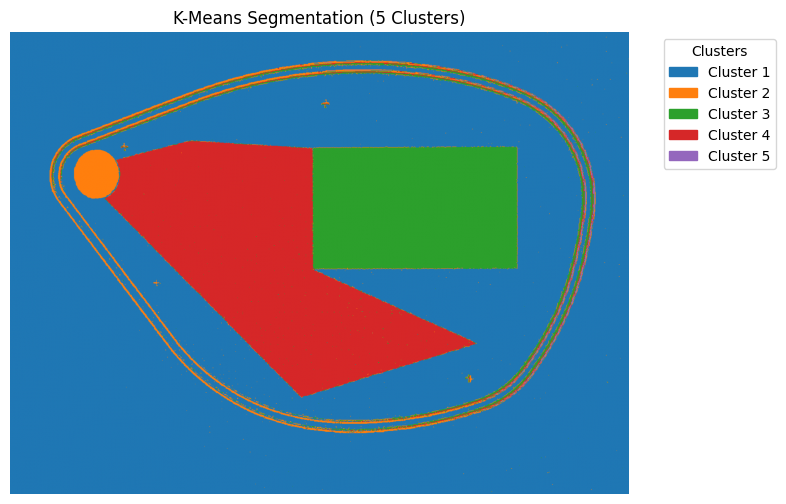

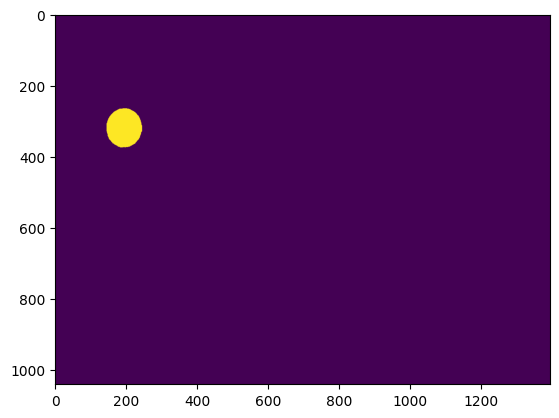

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


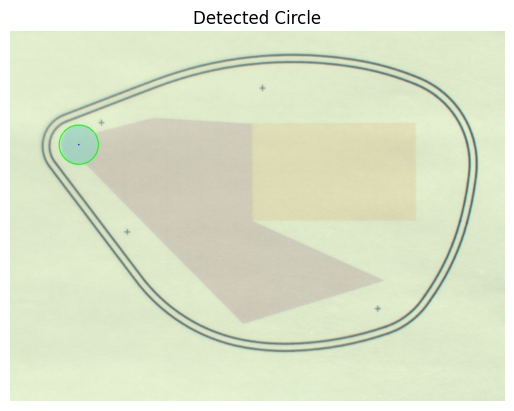

Processing d3...


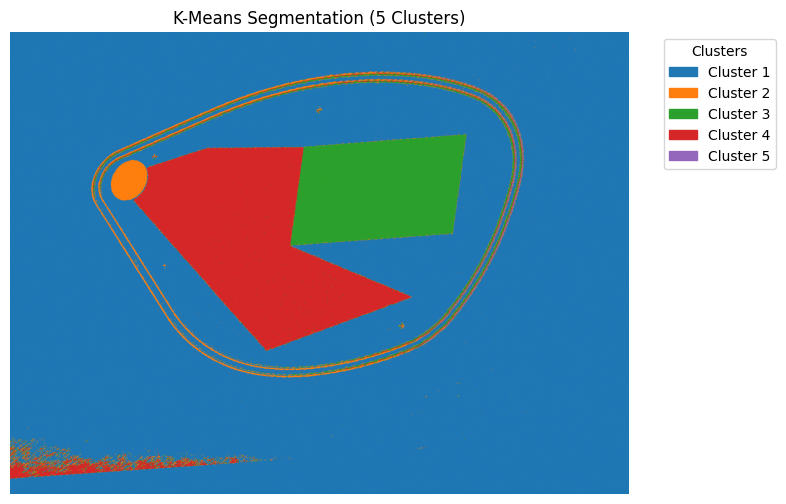

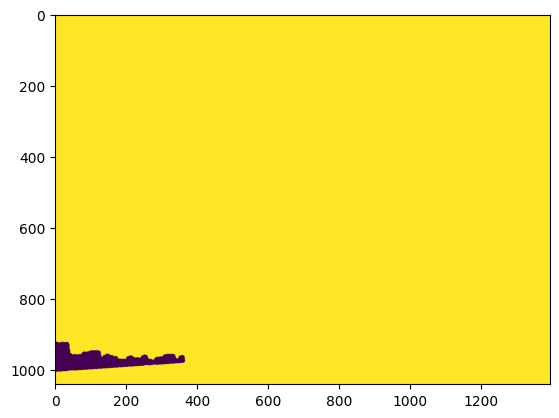

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


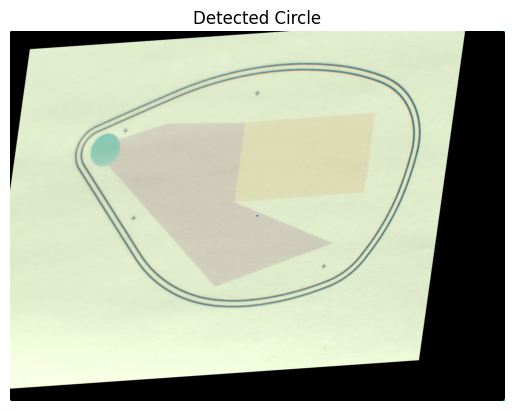

Processing d4...


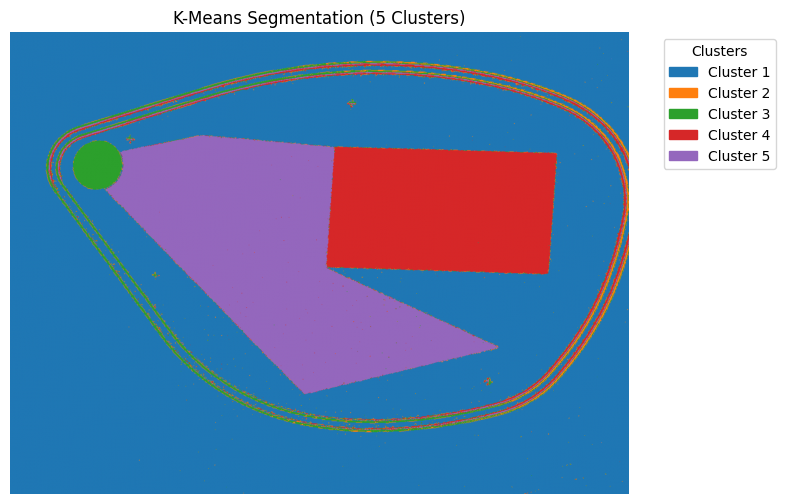

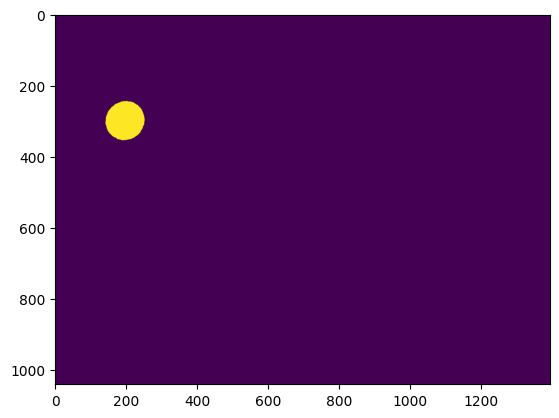

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


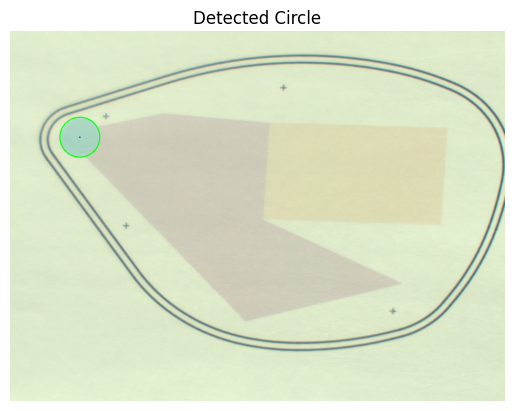

Processing d7...


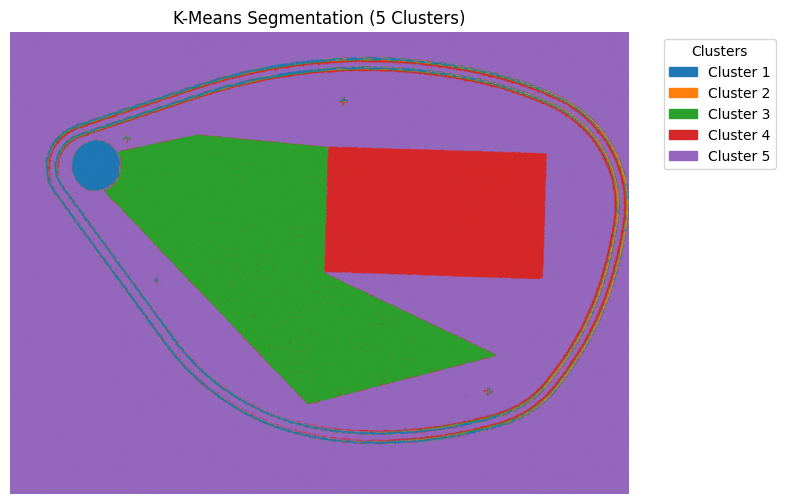

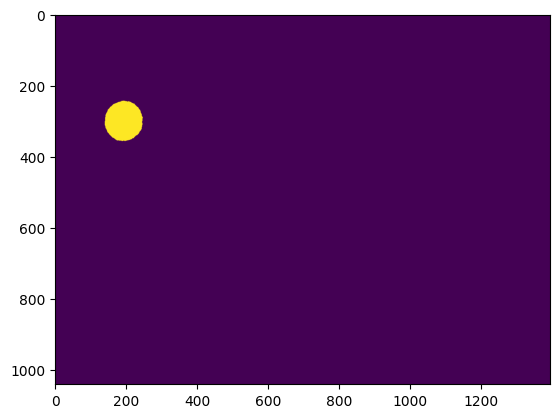

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


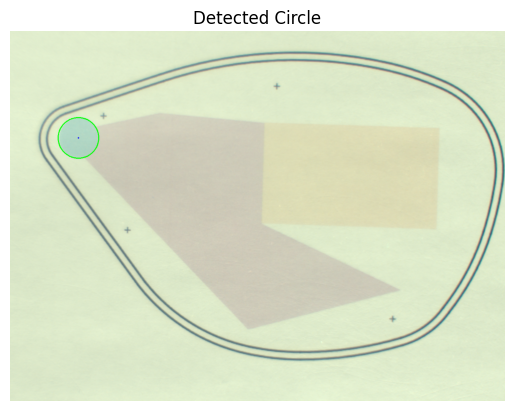

Processing d10...


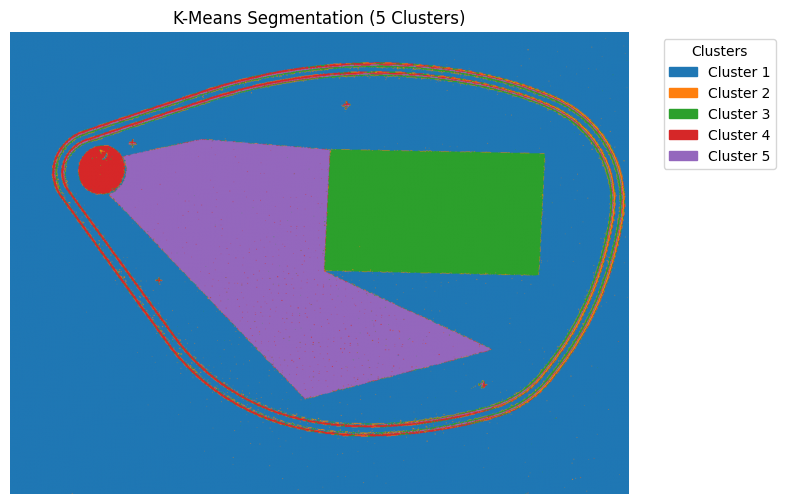

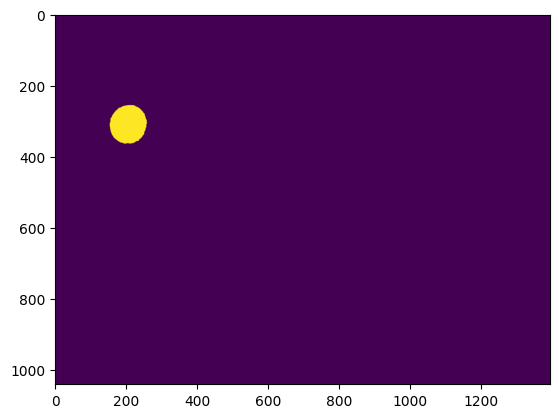

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


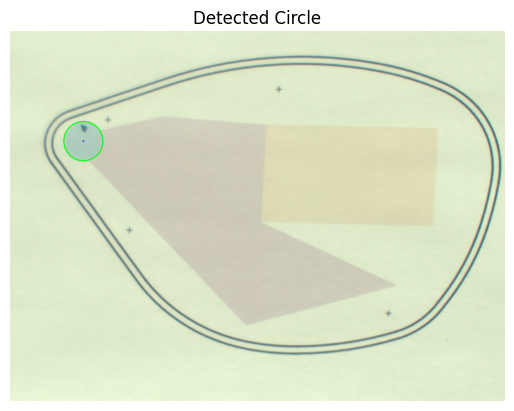

Processing d12...


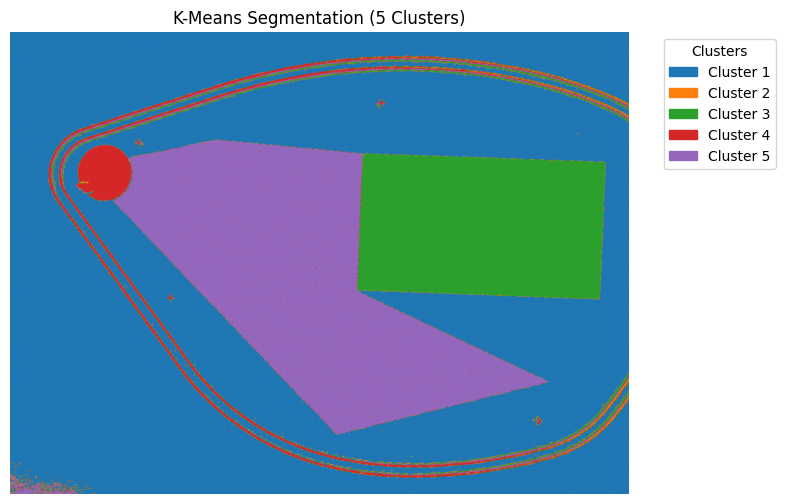

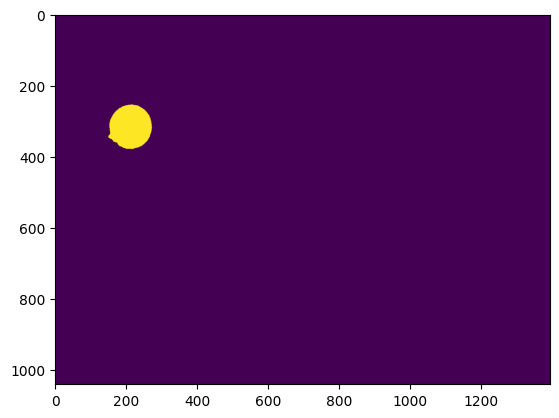

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


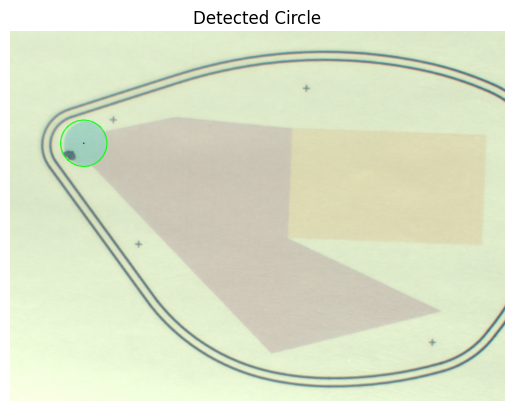

Processing d13...


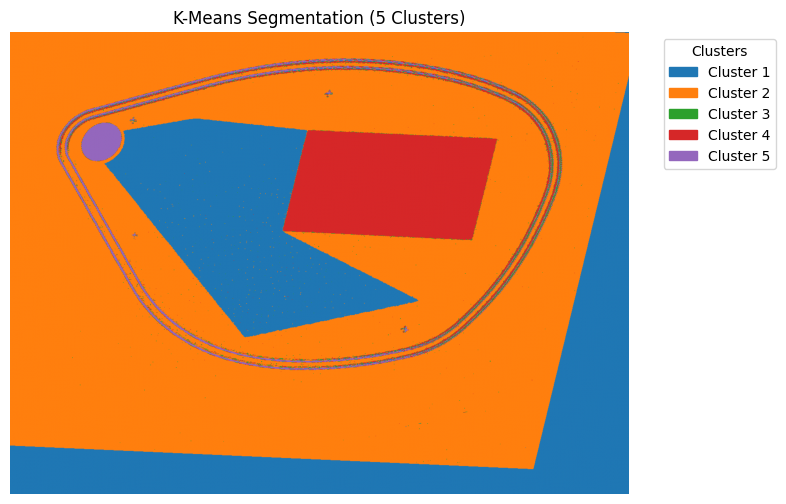

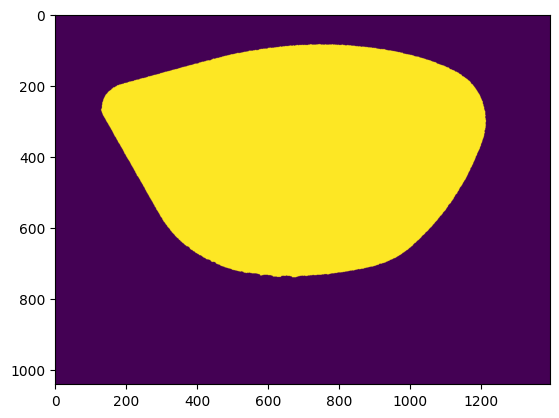

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


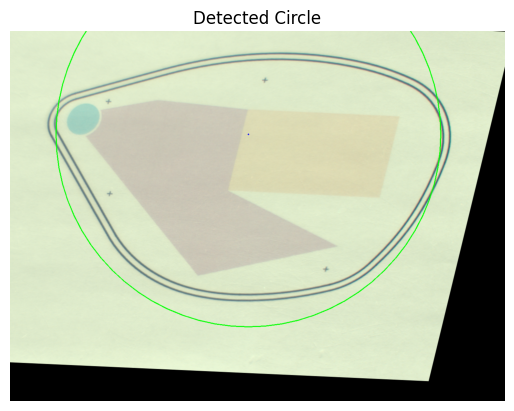

Processing d18...


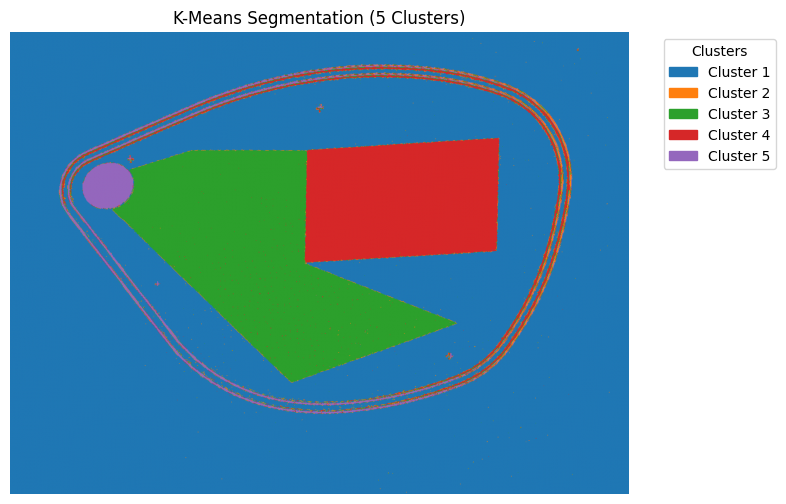

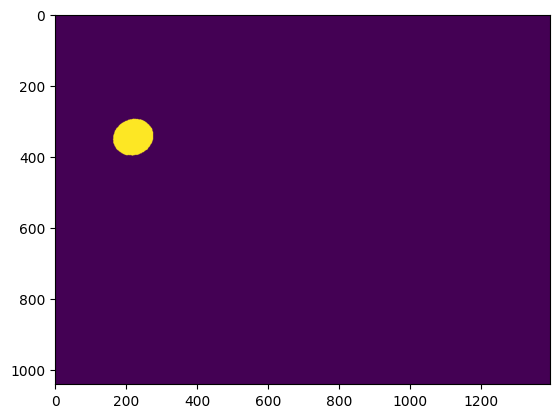

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


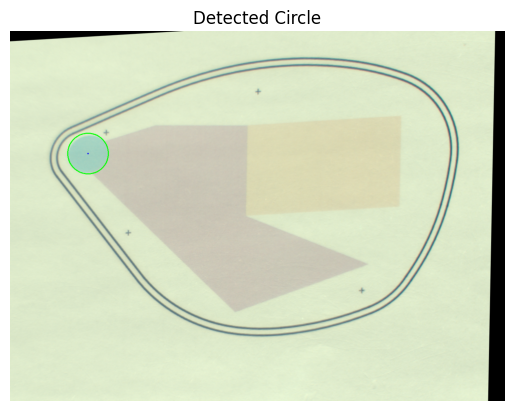

Processing d19...


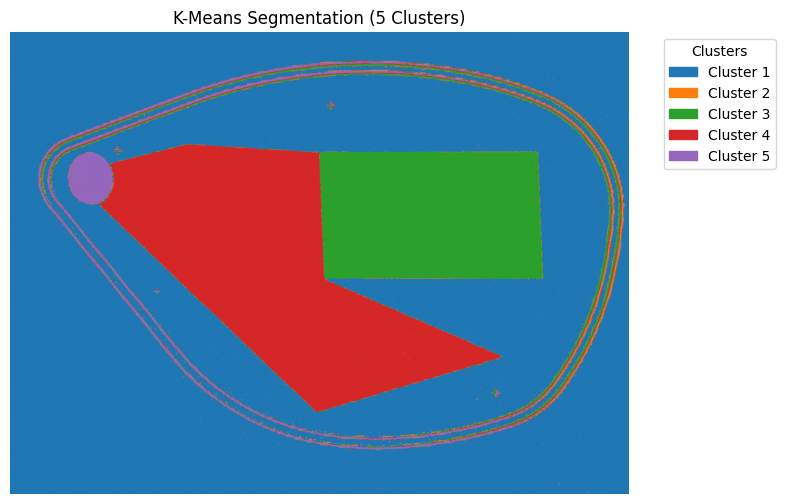

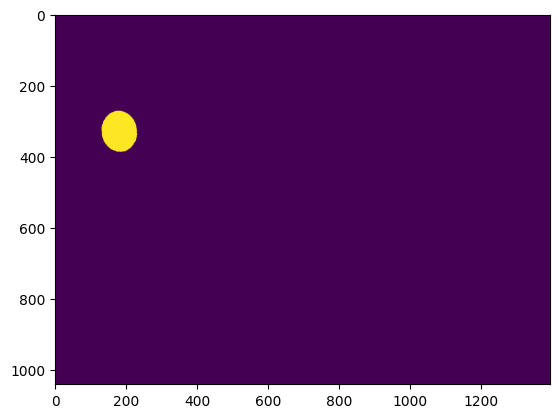

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


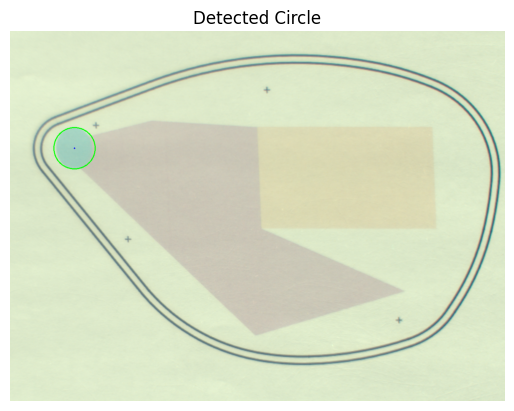

Processing d20...


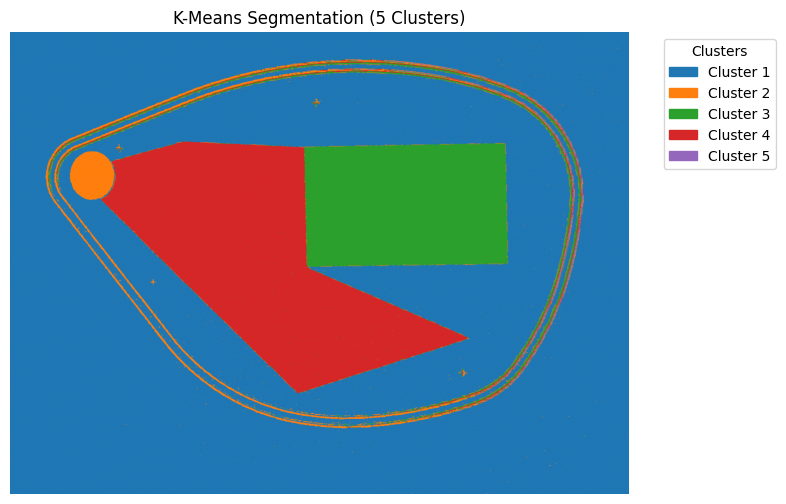

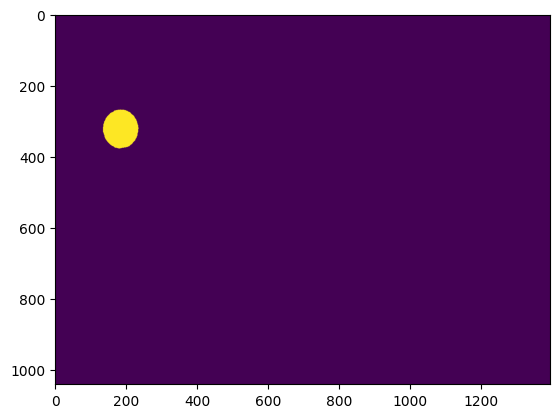

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


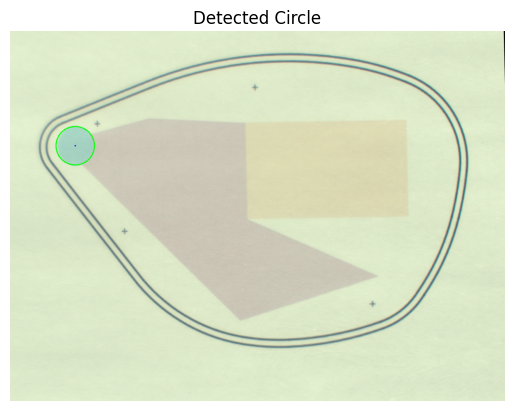

Processing d21...


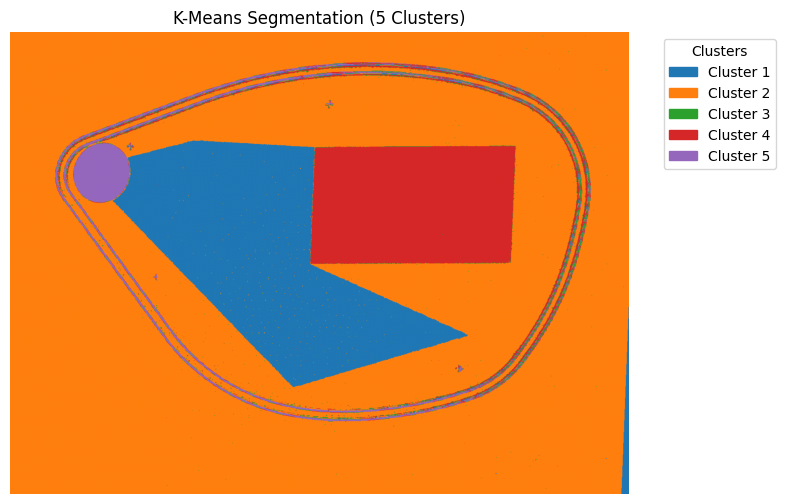

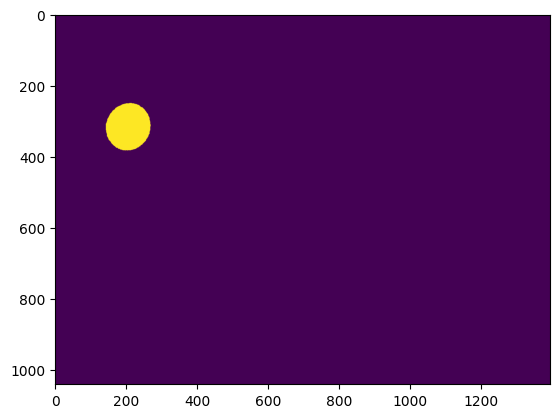

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


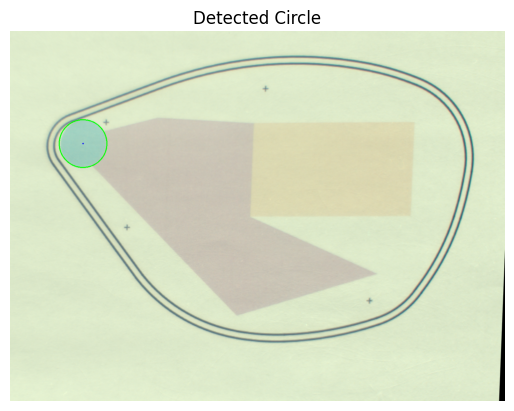

Processing d22...


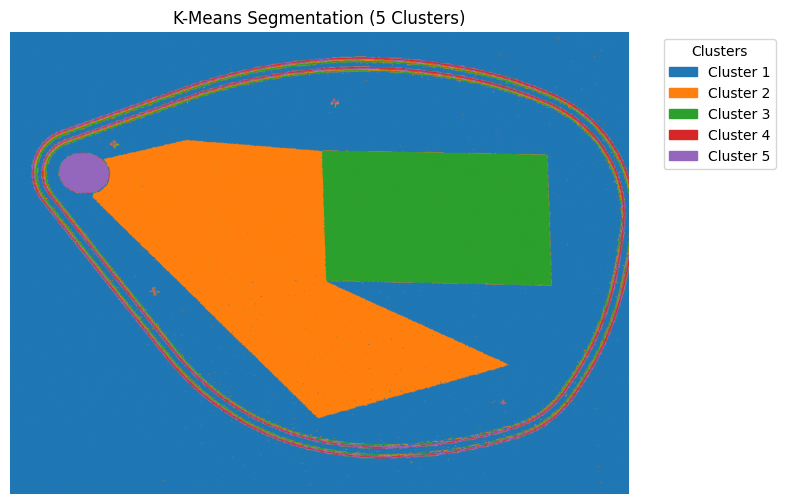

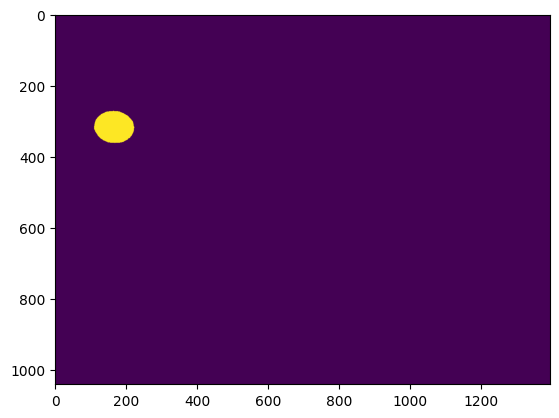

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


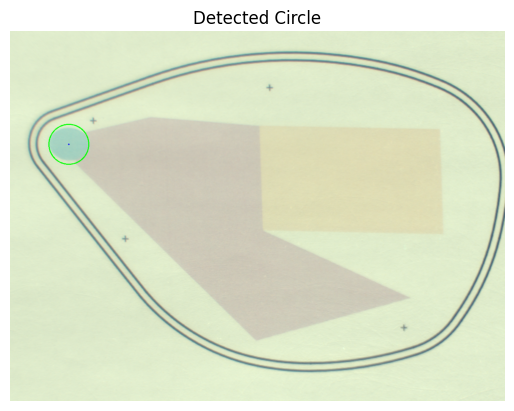

In [ ]:
deltaE_results = []
defects_radius = []
defects_aligned = []

for i, defect_name in enumerate(defects):
    print(f"Processing {defect_name}...")

    # CTQ2 (in RGB)
    # Align defect
    A_3x3 = defect_homographies[i]
    A_2x3 = A_3x3[:2, :]
    defect_rgb = spim2rgb(defect_cubes[defect_name], wavelengths)
    h, w, b = defect_rgb.shape
    aligned_defect = cv2.warpAffine(defect_rgb, A_2x3, (w, h))
    defects_aligned.append(aligned_defect)

    # Compute defect mask of IC to find circle radius
    defect_mask = compute_IC_mask(defect_rgb, A_2x3, True)
    defect_circle_info = get_circle_info(defect_mask, aligned_defect, True)
    defects_radius.append(defect_circle_info["min_enclosing_circle"]["radius"])

    # CTQ1 (all spectra)
    # Compute spectral average
    cube = defect_cubes[defect_name]
    bands, h, w = cube.shape

    # Align full cube
    cube_aligned = np.stack(
        [cv2.warpAffine(cube[j], A_3x3[:2, :], (w, h)) for j in range(bands)]
    )

    # Spectral to XYZ to LAB
    cube_interp, _ = interpolate_spectral_cube(
        cube_aligned, wavelengths, wl_min=360, wl_max=830, wl_step=10
    )
    cube_interp = np.transpose(cube_interp, (1, 2, 0))  # (H, W, b)

    def_XYZ = spim2XYZ(cube_interp, new_wavelengths, "D65")
    def_LAB = XYZ2Lab(def_XYZ, new_wavelengths, "D65")

    # CIelab delta E with reference
    DE_mean = calculate_delta_E(ref_LAB, def_LAB, mask=mask_ref)
    deltaE_results.append(DE_mean)

In [ ]:
defects_radius

[49.87149429321289,
 50.05008316040039,
 49.851051330566406,
 49.99308776855469,
 49.995723724365234,
 50.61529541015625,
 46.60750198364258,
 55.41777420043945,
 49.844093322753906,
 50.01009750366211,
 62.229515075683594,
 46.50999069213867]

In [ ]:
for i in abs(np.array(defects_radius) - 50):
    print(i)

0.12850570678710938
0.050083160400390625
0.14894866943359375
0.0069122314453125
0.004276275634765625
0.61529541015625
3.392498016357422
5.417774200439453
0.15590667724609375
0.010097503662109375
12.229515075683594
3.490009307861328


In [ ]:
for i in abs(np.array(defects_radius) - 50) > 1.2:
    print(i)
    

False
False
False
False
False
False
True
True
False
False
True
True


7. Create df to save results


In [ ]:
# Save results to df
result_df = pd.DataFrame()
result_df["defect_id"] = defects
result_df["DE_mean"] = deltaE_results
result_df["radius"] = defects_radius
result_df["CTQ1"] = np.array(deltaE_results) > 2.8
result_df["CTQ2"] = abs(np.array(defects_radius) - 57) > 1.2 # new reference  50 
result_df["Defect?"] = result_df["CTQ1"] | result_df["CTQ2"]
result_df.to_csv("deltaE_results.csv", index=False)
print("\nAverage DE (CIE2000) values per defect:")
print(result_df)

NameError: name 'deltaE_results' is not defined

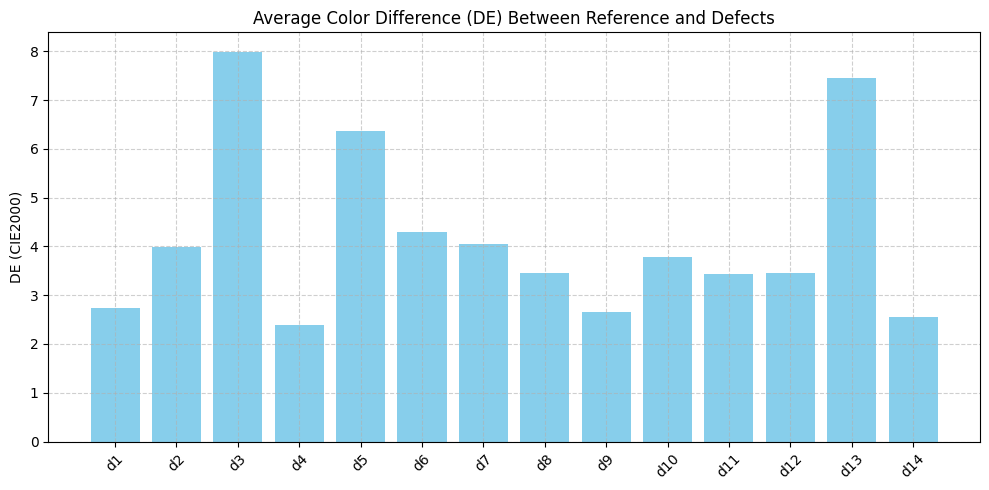

In [ ]:
# Plot delta E differences
plt.figure(figsize=(10, 5))
plt.bar(result_df["defect_id"], result_df["DE_mean"], color="skyblue")
plt.ylabel("DE (CIE2000)")
plt.title("Average Color Difference (DE) Between Reference and Defects")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

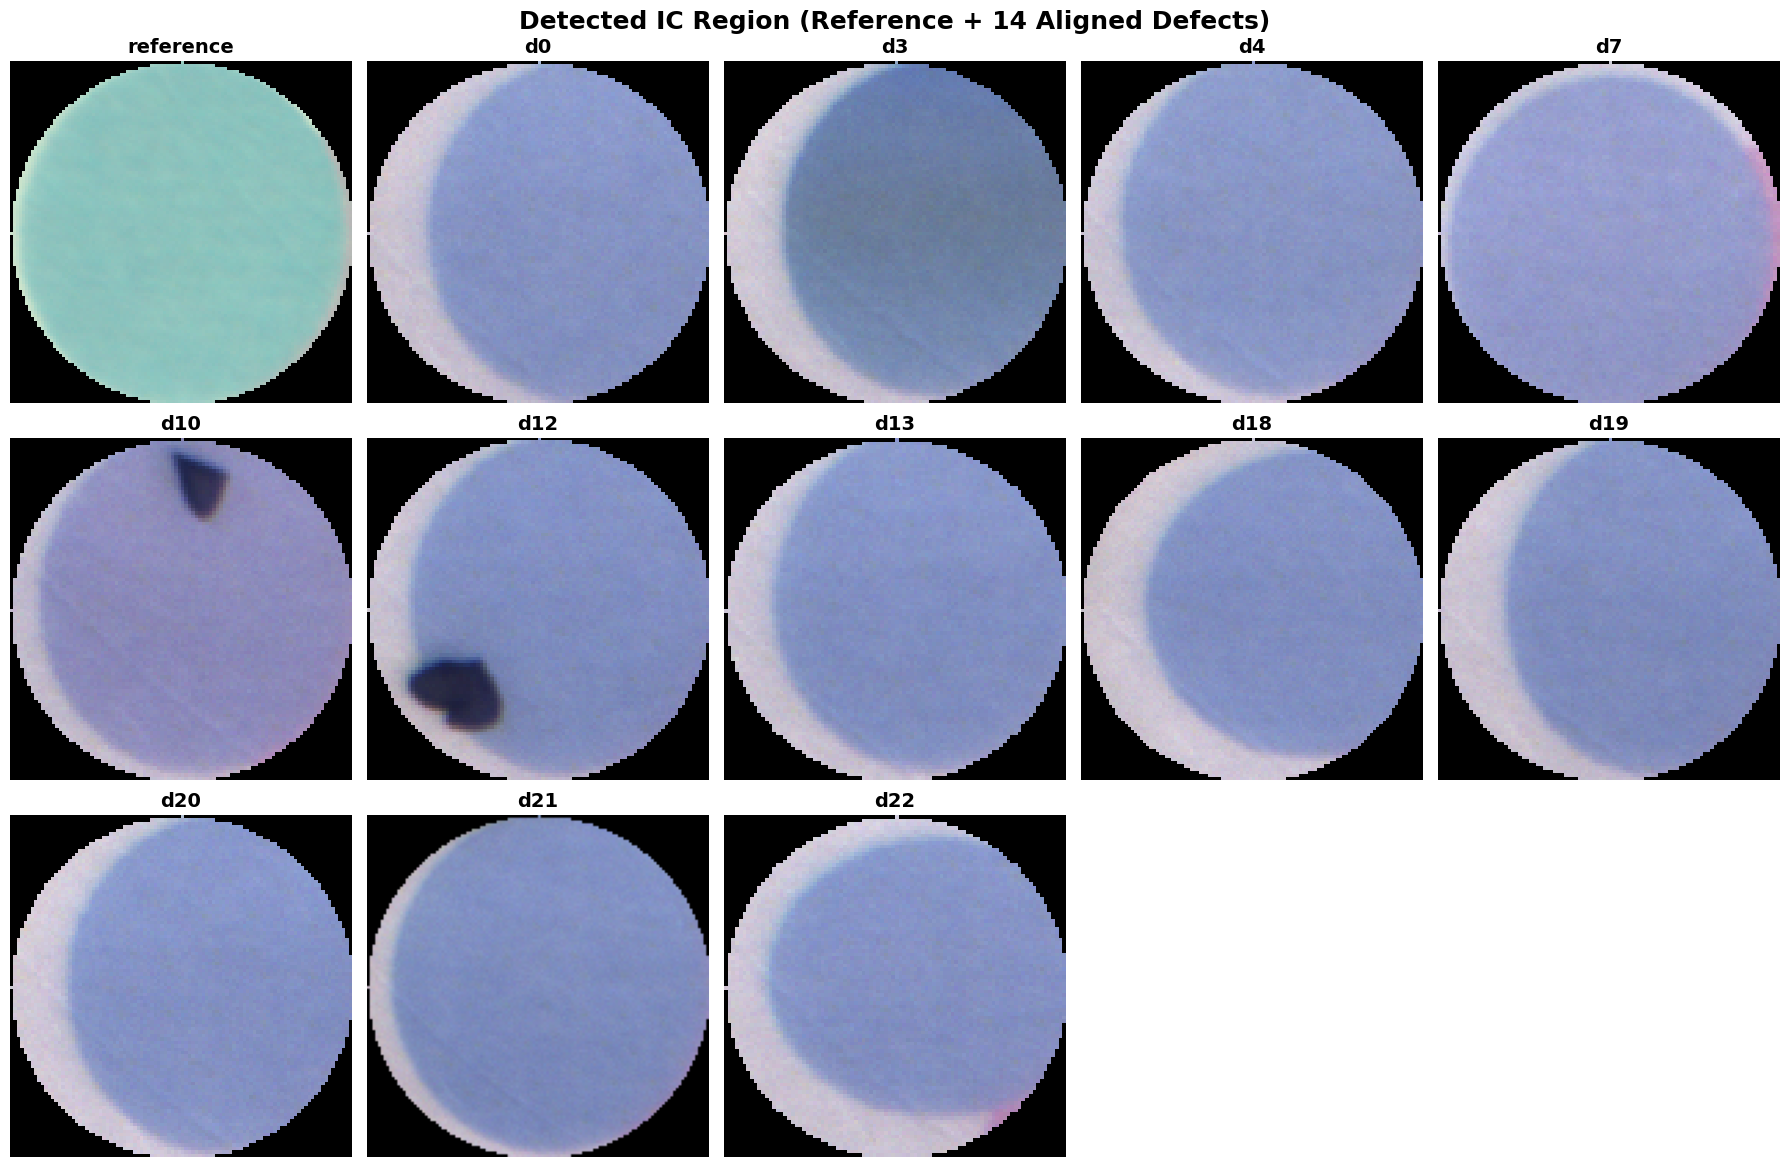

In [ ]:
# Plot masked IC region
"""ref_cropped = crop_circle(ref_rgb, circle_center, circle_radius)
cropped_circles = [ref_cropped]
for i in range(len(defects)):
    cropped_circle = crop_circle(defects_aligned[i], circle_center, circle_radius)
    cropped_circles.append(cropped_circle)"""

titles = ["reference"] + defects
plt.figure(figsize=(18, 12))
cols = 5
rows = math.ceil((len(defects) + 1) / cols)
for idx, (img, title) in enumerate(zip(cropped_circles, titles)):
    plt.subplot(rows, cols, idx + 1)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis("off")

plt.suptitle(
    "Detected IC Region (Reference + 14 Aligned Defects)",
    fontsize=18,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

6. Average reflectance in Circle


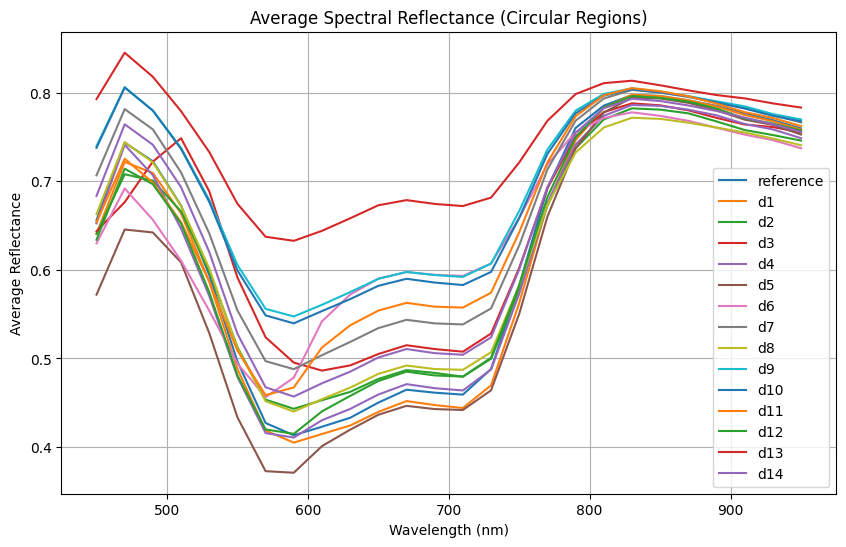

In [ ]:
# Plot average spectra of each defect
for defect_name in defects:
    cube = defect_cubes[defect_name]
    spec = average_reflectance_in_circle(
        cube, circle_center, circle_radius, transform=A_3x3
    )
    spectra[defect_name] = spec
plt.figure(figsize=(10, 6))
for name, spectrum in spectra.items():
    # if name == "reference" or name == "d4":
    #     plt.plot(wavelengths, spectrum, label=name)
    plt.plot(wavelengths, spectrum, label=name)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Reflectance")
plt.title("Average Spectral Reflectance (Circular Regions)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def std_reflectance_in_circle(hypercube, center, radius, transform=None):
    bands, h, w = hypercube.shape

    hypercube_aligned = np.stack(
        [cv2.warpPerspective(hypercube[i], transform, (w, h)) for i in range(bands)]
    )

    mask = np.zeros((h, w), dtype=np.uint8)
    cx, cy = int(round(center[0])), int(round(center[1]))
    r = int(radius) - 5
    cv2.circle(mask, (cx, cy), r, 1, -1)

    std_reflectance = []
    for i in range(bands):
        band = hypercube_aligned[i]
        masked_pixels = band[mask == 1]
        if masked_pixels.size > 0:
            std_reflectance.append(np.std(masked_pixels))
        else:
            std_reflectance.append(np.nan)

    return np.array(std_reflectance)


new_spectra = {}
new_spectra_std = {}

for defect_name, transform in zip(defects, defect_homographies):
    cube = defect_cubes[defect_name]
    new_spectra[defect_name] = average_reflectance_in_circle(
        cube, circle_center, circle_radius, transform=transform
    )
    new_spectra_std[defect_name] = std_reflectance_in_circle(
        cube, circle_center, circle_radius, transform=transform
    )


for defect_name in defects:
    std_values = new_spectra_std[defect_name]
    mean_values = new_spectra[defect_name]

    print(
        f"{defect_name}: Mean Std across wavelengths = {np.nanmean(std_values):.6f}, Coefficient of Variation (mean) = {np.nanmean(std_values/mean_values)*100:.2f}%"
    )

d1: Mean Std across wavelengths = 0.030633, Coefficient of Variation (mean) = 6.16%
d2: Mean Std across wavelengths = 0.034854, Coefficient of Variation (mean) = 7.61%
d3: Mean Std across wavelengths = 0.013434, Coefficient of Variation (mean) = 2.21%
d4: Mean Std across wavelengths = 0.011729, Coefficient of Variation (mean) = 2.03%
d5: Mean Std across wavelengths = 0.014608, Coefficient of Variation (mean) = 3.07%
d6: Mean Std across wavelengths = 0.106507, Coefficient of Variation (mean) = 17.76%
d7: Mean Std across wavelengths = 0.052024, Coefficient of Variation (mean) = 8.94%
d8: Mean Std across wavelengths = 0.084006, Coefficient of Variation (mean) = 13.66%
d9: Mean Std across wavelengths = 0.026222, Coefficient of Variation (mean) = 4.57%
d10: Mean Std across wavelengths = 0.038400, Coefficient of Variation (mean) = 6.64%
d11: Mean Std across wavelengths = 0.044006, Coefficient of Variation (mean) = 8.76%
d12: Mean Std across wavelengths = 0.043673, Coefficient of Variation (m

In [ ]:
avg_std_per_defect = {
    name: np.nanmean(std_values) for name, std_values in new_spectra_std.items()
}

sorted_defects = sorted(avg_std_per_defect.items(), key=lambda x: x[1], reverse=True)
for rank, (name, std_val) in enumerate(sorted_defects, 1):
    print(f"{name}: {std_val:.6f}")

d6: 0.106507
d13: 0.084506
d8: 0.084006
d7: 0.052024
d11: 0.044006
d12: 0.043673
d10: 0.038400
d2: 0.034854
d1: 0.030633
d9: 0.026222
d5: 0.014608
d14: 0.013473
d3: 0.013434
d4: 0.011729
